## Analisis Sentimen Pemindahan Ibukota
### Oleh: Hana Amalia Kushandini

**Sumber Dataset:** https://github.com/varaah/analisis-sentimen-ikn \
**Deskripsi:** Dataset yang digunakan merupakan hasil tweet yang berisi pendapat para pengguna twitter mengenai pemindahan Ibukota dari Jakarta ke Kalimantan. Pendapat yang dikumpulkan dari twitter tersebut dibagi menjadi kategori *positive* (1) dan *negative* (0), yang selanjutnya digunakan sebagai label dalam data.

In [1]:
!pip -q install PySastrawi

In [2]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.models import load_model

In [3]:
url1 = "https://raw.githubusercontent.com/varaah/analisis-sentimen-ikn/main/data/twitterIKN-labelled_new.csv"
df = pd.read_csv(url1)

In [4]:
df

,author id,date,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,target
0,1.484686e+18,2022-01-27,2022-01-27T07:27:53.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter Web App,#AyoTolakUUIKN \n\nProyek IKN membuka peluang ...,0
1,1.464432e+18,2022-01-27,2022-01-27T07:27:54.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter for Android,Tolak UU IKN karena berpotensi merusak lingkun...,0
2,8.852835e+17,2022-01-27,2022-01-27T07:28:03.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter Web App,UU IKN hanya akan merugikan rakyat dengan huta...,0
3,1.384007e+18,2022-01-27,2022-01-27T07:28:04.000Z,NaN,1.486602e+18,in,1,0,0,0,Twitter Web App,Jika UU ini diterapkan yang terjadi adalah mas...,0
4,1.450712e+18,2022-01-27,2022-01-27T07:28:05.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter for Android,UU IKN Syarat kepentingan oligarki. Tolak n ba...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,1.349267e+18,2022-02-27,2022-02-27T23:44:22.000Z,NaN,1.498082e+18,in,16,6,2,16,Twitter for Android,♻Visi Pembangunan IKN♻\n\nIKN akan dibangun de...,1
1723,3.225593e+08,2022-02-27,2022-02-27T23:46:29.000Z,NaN,1.498082e+18,in,20,1,2,20,Twitter for Android,✍️ Menteri @Suharso_M: Berada di Tengah Indone...,1
1724,3.225593e+08,2022-02-27,2022-02-27T23:53:35.000Z,NaN,1.498084e+18,in,19,1,1,19,Twitter for Android,✍️ Visi Pembangunan IKN\n\nIKN akan dibangun d...,1
1725,2.438712e+09,2022-02-27,2022-02-27T23:55:13.000Z,NaN,1.498084e+18,in,24,0,2,23,Twitter Web App,"Berada di tengah Indonesia, IKN diharapkan men...",1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author id      1727 non-null   float64
 1   date           1727 non-null   object 
 2   created_at     1727 non-null   object 
 3   geo            44 non-null     object 
 4   id             1727 non-null   float64
 5   lang           1727 non-null   object 
 6   like_count     1727 non-null   int64  
 7   quote_count    1727 non-null   int64  
 8   reply_count    1727 non-null   int64  
 9   retweet_count  1727 non-null   int64  
 10  source         1727 non-null   object 
 11  tweet          1727 non-null   object 
 12  target         1727 non-null   int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 175.5+ KB


In [6]:
df.describe()

,author id,id,like_count,quote_count,reply_count,retweet_count,target
count,1.727000e+03,1.727000e+03,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,9.449191e+17,1.490171e+18,37.965258,1.297626,5.723798,13.046323,0.501448
std,5.936940e+17,4.613171e+15,208.198962,8.527952,39.339678,52.015219,0.500143
min,1.468965e+07,1.486602e+18,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.107554e+09,1.486651e+18,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.262157e+18,1.487550e+18,2.000000,0.000000,0.000000,1.000000,1.000000
75%,1.398347e+18,1.496372e+18,15.000000,0.000000,1.000000,9.000000,1.000000
max,1.493145e+18,1.498085e+18,5522.000000,221.000000,1159.000000,920.000000,1.000000


In [7]:
df["target"].value_counts()

1    866
0    861
Name: target, dtype: int64

### Text Preprocessing

In [8]:
def lowercase(text):
    return text.lower()

table = str.maketrans("", "", string.punctuation)
def remove_puncts(text):
    return text.translate(table)

def stem_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

def remove_url(text):
    url = re.compile(r"https?(://\S+|\S+)|www\.\S+")
    return url.sub("", text)

def remove_username(text):
    return re.sub('@[\w]+','', text)

def preprocess_text(text):
    text = lowercase(text)
    text = remove_url(text)
    text = remove_puncts(text)
    text = stem_text(text)
    text = remove_username(text)
    return text

In [9]:
df["tweet_cleaned"] = df["tweet"].apply(preprocess_text)
df.head()

,author id,date,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,target,tweet_cleaned
0,1.484686e+18,2022-01-27,2022-01-27T07:27:53.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter Web App,#AyoTolakUUIKN \n\nProyek IKN membuka peluang ...,0,ayotolakuuikn proyek ikn buka peluang besar pa...
1,1.464432e+18,2022-01-27,2022-01-27T07:27:54.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter for Android,Tolak UU IKN karena berpotensi merusak lingkun...,0,tolak uu ikn karena potensi rusak lingkung dan...
2,8.852835e+17,2022-01-27,2022-01-27T07:28:03.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter Web App,UU IKN hanya akan merugikan rakyat dengan huta...,0,uu ikn hanya akan rugi rakyat dengan hutang ri...
3,1.384007e+18,2022-01-27,2022-01-27T07:28:04.000Z,NaN,1.486602e+18,in,1,0,0,0,Twitter Web App,Jika UU ini diterapkan yang terjadi adalah mas...,0,jika uu ini terap yang jadi adalah masyarakat ...
4,1.450712e+18,2022-01-27,2022-01-27T07:28:05.000Z,NaN,1.486602e+18,in,0,0,0,0,Twitter for Android,UU IKN Syarat kepentingan oligarki. Tolak n ba...,0,uu ikn syarat penting oligarki tolak n batal s...


In [10]:
df["tweet_cleaned"]

0       ayotolakuuikn proyek ikn buka peluang besar pa...
1       tolak uu ikn karena potensi rusak lingkung dan...
2       uu ikn hanya akan rugi rakyat dengan hutang ri...
3       jika uu ini terap yang jadi adalah masyarakat ...
4       uu ikn syarat penting oligarki tolak n batal s...
                              ...                        
1722    visi bangun ikn ikn akan bangun dengan visi ko...
1723    menteri suharsom ada di tengah indonesia ikn h...
1724    visi bangun ikn ikn akan bangun dengan visi ko...
1725    ada di tengah indonesia ikn harap jadi pusat g...
1726    bangun ikn usung konsep future smart forest ci...
Name: tweet_cleaned, Length: 1727, dtype: object

### Modeling

In [11]:
maxlen = df["tweet_cleaned"].str.split().str.len().max()
maxlen

48

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df["tweet_cleaned"], df["target"], shuffle=True, test_size=0.20)

In [13]:
#tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)

#update kosa kata
tokenizer.fit_on_texts(df["tweet_cleaned"])

#ubah teks menjadi sequence
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

#samakan panjang kalimat
X_train_sequence = keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=maxlen, padding="post")
X_test_sequence = keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=maxlen, padding="post")

In [14]:
X_train_sequence.shape

(1381, 48)

In [15]:
#parameter
BATCH_SIZE = 32
epoch = 100
EMBEDDING_DIM = 32

In [16]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('binary_accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [17]:
#fungsi untuk memplot hasil training
def history_line_plot(history, keys, title=""):
    for key in keys:
        plt.plot(history[key], label=key)
    plt.title(title)
    plt.legend()
    plt.show()

#### RNN Model

In [18]:
#membangun model
inputs = keras.layers.Input(shape=(maxlen,))
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)
x = keras.layers.SimpleRNN(16)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model_rnn = keras.models.Model(inputs=inputs, outputs=outputs)
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 embedding (Embedding)       (None, 48, 32)            320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 320,801
Trainable params: 320,801
Non-trainable params: 0
_________________________________________________________________


In [19]:
#training model
history_rnn = model_rnn.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=epoch,
    validation_split=0.2,
    callbacks=[myCallback()])

Epoch 1/100
35/35 [==============================] - 4s 54ms/step - loss: 0.6829 - binary_accuracy: 0.5507 - val_loss: 0.6643 - val_binary_accuracy: 0.6245
Epoch 2/100
35/35 [==============================] - 2s 49ms/step - loss: 0.4569 - binary_accuracy: 0.8732 - val_loss: 0.5820 - val_binary_accuracy: 0.6859
Epoch 3/100
35/35 [==============================] - 2s 51ms/step - loss: 0.2326 - binary_accuracy: 0.9638 - val_loss: 0.5555 - val_binary_accuracy: 0.7329
Epoch 4/100
35/35 [==============================] - 2s 48ms/step - loss: 0.1233 - binary_accuracy: 0.9873 - val_loss: 0.5680 - val_binary_accuracy: 0.7184
Epoch 5/100
35/35 [==============================] - ETA: 0s - loss: 0.0755 - binary_accuracy: 0.9982
Reached 99% accuracy so cancelling training!
35/35 [==============================] - 2s 47ms/step - loss: 0.0755 - binary_accuracy: 0.9982 - val_loss: 0.5736 - val_binary_accuracy: 0.7401


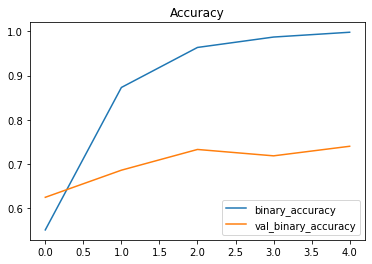

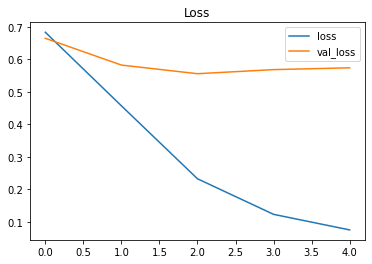

In [20]:
history_line_plot(
    history=history_rnn.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy")

history_line_plot(
    history=history_rnn.history, 
    keys=["loss", "val_loss"],
    title="Loss")

### LSTM

In [21]:
#membangun model
inputs = keras.layers.Input(shape=(maxlen,))
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)
x = keras.layers.LSTM(16)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model_lstm = keras.models.Model(inputs=inputs, outputs=outputs)
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 48, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training model
history_lstm = model_lstm.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=epoch,
    validation_split=0.2,
    callbacks=[myCallback()])

Epoch 1/100
35/35 [==============================] - 3s 19ms/step - loss: 0.6938 - binary_accuracy: 0.5091 - val_loss: 0.6943 - val_binary_accuracy: 0.4657
Epoch 2/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6689 - binary_accuracy: 0.6721 - val_loss: 0.5310 - val_binary_accuracy: 0.8989
Epoch 3/100
35/35 [==============================] - 0s 9ms/step - loss: 0.3539 - binary_accuracy: 0.9339 - val_loss: 0.2943 - val_binary_accuracy: 0.9170
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.1659 - binary_accuracy: 0.9755 - val_loss: 0.2787 - val_binary_accuracy: 0.9206
Epoch 5/100
35/35 [==============================] - 0s 7ms/step - loss: 0.1404 - binary_accuracy: 0.9728 - val_loss: 0.2176 - val_binary_accuracy: 0.9350
Epoch 6/100
35/35 [==============================] - 0s 8ms/step - loss: 0.0807 - binary_accuracy: 0.9882 - val_loss: 0.2639 - val_binary_accuracy: 0.9206
Epoch 7/100
35/35 [==============================] - 0s 7ms/step - lo

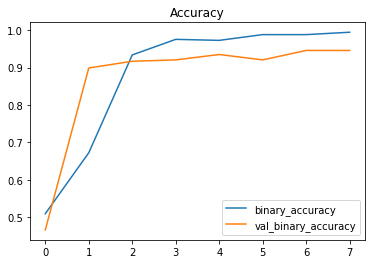

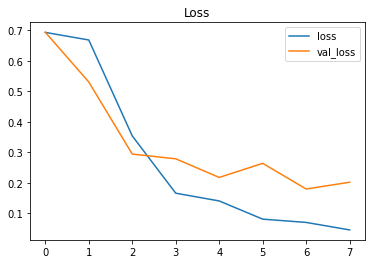

In [23]:
history_line_plot(
    history=history_lstm.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy")

history_line_plot(
    history=history_lstm.history, 
    keys=["loss", "val_loss"],
    title="Loss")

### GRU

In [24]:
#membangun model
inputs = keras.layers.Input(shape=(maxlen,))
x = keras.layers.Embedding(10000, EMBEDDING_DIM, input_length=maxlen)(inputs)
x = keras.layers.GRU(16)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model_gru = keras.models.Model(inputs=inputs, outputs=outputs)
model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 48, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 322,417
Trainable params: 322,417
Non-trainable params: 0
_________________________________________________________________


In [25]:
#training model
history_gru = model_gru.fit(
    x=X_train_sequence,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=epoch,
    validation_split=0.2,
    callbacks=[myCallback()])

Epoch 1/100
35/35 [==============================] - 2s 19ms/step - loss: 0.6937 - binary_accuracy: 0.5136 - val_loss: 0.6962 - val_binary_accuracy: 0.4657
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.6932 - binary_accuracy: 0.5136 - val_loss: 0.6955 - val_binary_accuracy: 0.4657
Epoch 3/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6933 - binary_accuracy: 0.5145 - val_loss: 0.6956 - val_binary_accuracy: 0.4657
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6929 - binary_accuracy: 0.5154 - val_loss: 0.6948 - val_binary_accuracy: 0.4657
Epoch 5/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6929 - binary_accuracy: 0.5154 - val_loss: 0.6963 - val_binary_accuracy: 0.4657
Epoch 6/100
35/35 [==============================] - 0s 8ms/step - loss: 0.6925 - binary_accuracy: 0.5172 - val_loss: 0.6947 - val_binary_accuracy: 0.4657
Epoch 7/100
35/35 [==============================] - 0s 7ms/step - lo

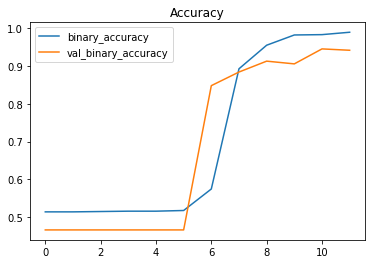

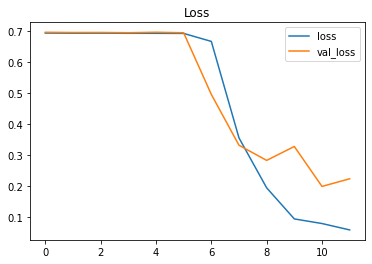

In [26]:
history_line_plot(
    history=history_gru.history, 
    keys=["binary_accuracy", "val_binary_accuracy"],
    title="Accuracy")

history_line_plot(
    history=history_gru.history, 
    keys=["loss", "val_loss"],
    title="Loss")

### Evaluasi dan Prediksi

In [27]:
loss1, acc1 = model_rnn.evaluate(X_test_sequence, y_test)
print(f"RNN Model test loss: {loss1}")
print(f"RNN Model test acc: {acc1}")

11/11 [==============================] - 0s 6ms/step - loss: 0.5493 - binary_accuracy: 0.7370
RNN Model test loss: 0.5492656826972961
RNN Model test acc: 0.736994206905365


In [28]:
loss2, acc2 = model_lstm.evaluate(X_test_sequence, y_test)
print(f"LSTM Model test loss: {loss2}")
print(f"LSTM Model test acc: {acc2}")

11/11 [==============================] - 0s 3ms/step - loss: 0.3004 - binary_accuracy: 0.9191
LSTM Model test loss: 0.30041995644569397
LSTM Model test acc: 0.9190751314163208


In [29]:
loss3, acc3 = model_gru.evaluate(X_test_sequence, y_test)
print(f"GRU Model test loss: {loss3}")
print(f"GRU Model test acc: {acc3}")

11/11 [==============================] - 0s 3ms/step - loss: 0.3804 - binary_accuracy: 0.8931
GRU Model test loss: 0.38035106658935547
GRU Model test acc: 0.8930636048316956


In [34]:
def predict(texts, model):
    texts = [preprocess_text(text) for text in texts]
    seq = tokenizer.texts_to_sequences(texts)
    seq = keras.preprocessing.sequence.pad_sequences(seq, maxlen=maxlen, padding="post")
    probs = model.predict(seq)
    return probs


samples = [
           "saya menolak pemindahan ibukota", 
           "pemindahan ibukota hanya menambah hutang negara",
           "dukung pemindahan ibukota"
            ]

In [35]:
probs1 = predict(samples, model_rnn)

predictions1 = tf.where(probs1 > 0.5, "Positif", "Negatif")
predictions1 = tf.squeeze(predictions1, axis=-1)

for sample, prob, label in zip(samples, probs1, predictions1):
    print(f"Hasil Prediksi dengan RNN Model")
    print(f"Kalimat: {sample}")
    print(f"Probabilitas: {prob}")
    print(f"Label: {label.numpy().decode()}")
    print()

Hasil Prediksi dengan RNN Model
Kalimat: saya menolak pemindahan ibukota
Probabilitas: [0.02921679]
Label: Negatif

Hasil Prediksi dengan RNN Model
Kalimat: pemindahan ibukota hanya menambah hutang negara
Probabilitas: [0.02922635]
Label: Negatif

Hasil Prediksi dengan RNN Model
Kalimat: dukung pemindahan ibukota
Probabilitas: [0.9289846]
Label: Positif



In [36]:
probs2 = predict(samples, model_lstm)

predictions2 = tf.where(probs2 > 0.5, "Positif", "Negatif")
predictions2 = tf.squeeze(predictions2, axis=-1)

for sample, prob, label in zip(samples, probs2, predictions2):
    print(f"Hasil Prediksi dengan LSTM Model")
    print(f"Kalimat: {sample}")
    print(f"Probabilitas: {prob}")
    print(f"Label: {label.numpy().decode()}")
    print()

Hasil Prediksi dengan LSTM Model
Kalimat: saya menolak pemindahan ibukota
Probabilitas: [0.02680737]
Label: Negatif

Hasil Prediksi dengan LSTM Model
Kalimat: pemindahan ibukota hanya menambah hutang negara
Probabilitas: [0.02657262]
Label: Negatif

Hasil Prediksi dengan LSTM Model
Kalimat: dukung pemindahan ibukota
Probabilitas: [0.9805524]
Label: Positif



In [37]:
probs3 = predict(samples, model_gru)

predictions3 = tf.where(probs3 > 0.5, "Positif", "Negatif")
predictions3 = tf.squeeze(predictions3, axis=-1)

for sample, prob, label in zip(samples, probs3, predictions3):
    print(f"Hasil Prediksi dengan GRU Model")
    print(f"Kalimat: {sample}")
    print(f"Probabilitas: {prob}")
    print(f"Label: {label.numpy().decode()}")
    print()

Hasil Prediksi dengan GRU Model
Kalimat: saya menolak pemindahan ibukota
Probabilitas: [0.02442531]
Label: Negatif

Hasil Prediksi dengan GRU Model
Kalimat: pemindahan ibukota hanya menambah hutang negara
Probabilitas: [0.02451114]
Label: Negatif

Hasil Prediksi dengan GRU Model
Kalimat: dukung pemindahan ibukota
Probabilitas: [0.9825832]
Label: Positif



In [38]:
model_rnn.save('model_fix.h5')